# This is a demo on how to use the CTLIB package
The following demo applies filtered back projection (FBP) on a sparse view sinogram with 128 views and 512 detector bins to obtain a reconstruction using the function `ctlib.fbp`. The reconstruction is performed on a 256x256 grid. We also compare the Peak Signal to Noise Ratio (PSNR) of the reconstruction with the ground truth image. It is not hard to see there are aritifacts and loss of details in the reconstruction. This is due to the limited number of views and detector bins. We will see how we can improve the reconstruction using LAMA in the LAMA demo.

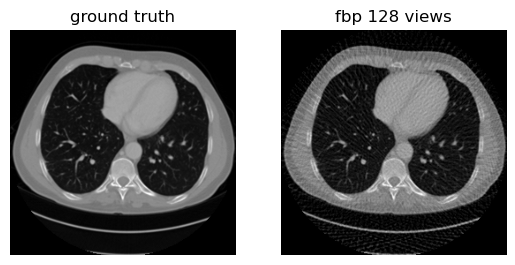

Result for fbp using 128 views: 
PSNR (128 views): 30.1668
SSIM (128 views): 0.8691


In [1]:
import warnings
warnings.filterwarnings('ignore')

import torch
import numpy as np
import matplotlib.pyplot as plt

import scipy.io as scio
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

import ctlib
from utils.CT_helper import generate_mask, load_CT_config
    
# load original image
image = scio.loadmat('dataset/image/data_0001.mat')['data']

# load sparse view sinogram with 128 views
sinogram = scio.loadmat('dataset/sinogram/data_0001.mat')['data']
views = sinogram.shape[0]
n_bins = sinogram.shape[1]
sinogram = torch.FloatTensor(sinogram).contiguous().cuda()

# options: views, dets, width, height, dImg, dDet, Ang0, dAng, s2r, d2r, binshift, scan_type
options_128views = load_CT_config("config/128views.yaml")

# reconstruct image by using fbp as an example using CTLIB
img_recon = ctlib.fbp(sinogram.view(1,1,views,n_bins) / 3.84, options_128views)
mask = generate_mask()
img_recon = img_recon.detach().cpu().numpy().squeeze().clip(0,1) * mask

fig, ax = plt.subplots(1,2)
ax[0].imshow(image, cmap='gray')
ax[0].axis('off')
ax[0].set_title('ground truth')

ax[1].imshow(img_recon, cmap='gray')
ax[1].axis('off')
ax[1].set_title('fbp 128 views')
plt.show()

print("Result for fbp using 128 views: ")
print('PSNR (128 views): {:.4f}'.format(psnr(img_recon.astype(image.dtype), image)))
print('SSIM (128 views): {:.4f}'.format(ssim(img_recon.astype(image.dtype), image)))

# Now we use another example to show how to perform cone beam radon transform.

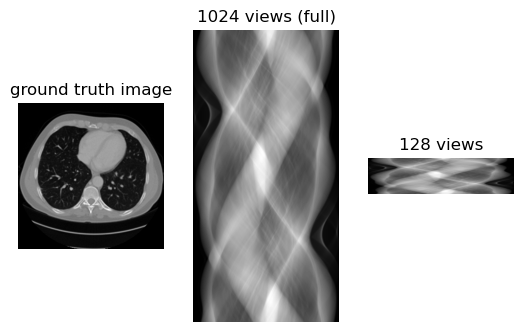

In [2]:
options_full = load_CT_config("config/full-view.yaml")
image = torch.FloatTensor(image).contiguous().cuda()
sinogram = ctlib.projection(image.view(1,1,image.shape[0],image.shape[1]), options_full)
sinogram_128 = ctlib.projection(image.view(1,1,image.shape[0],image.shape[1]), options_128views)

fig, ax = plt.subplots(1,3)
ax[0].imshow(image.detach().cpu().numpy(), cmap='gray')
ax[0].axis('off')
ax[0].set_title('ground truth image')

ax[1].imshow(sinogram.squeeze().detach().cpu().numpy(), cmap='gray')
ax[1].axis('off')
ax[1].set_title('1024 views (full)')

ax[2].imshow(sinogram_128.squeeze().detach().cpu().numpy(), cmap='gray')
ax[2].axis('off')
ax[2].set_title('128 views')

plt.show()